2025-03-23

In [ ]:
import requests
import pandas as pd

from google.colab import userdata
BEA_API_key = userdata.get('BEA_API_key')


# ====== USER INPUT ======
user_id = BEA_API_key  # Replace with your actual BEA API key
table_name = "T40206B" # Example: Imports
start_year = 1947
end_year = 2024
frequency = "Q"        # A = Annual, Q = Quarterly, M = Monthly
# =========================

# Convert year range to comma-separated string
years = ",".join(str(year) for year in range(start_year, end_year + 1))

# Base API URL
base_url = "https://apps.bea.gov/api/data"

# Parameters for the GET request
params = {
    "UserID": user_id,
    "method": "GetData",
    "DataSetName": "NIPA",
    "TableName": table_name,
    "Frequency": frequency,
    "Year": years,
    "ResultFormat": "JSON"
}

# Make the request
response = requests.get(base_url, params=params)

# Handle response
if response.status_code == 200:
    data = response.json()
    try:
        old_df = pd.DataFrame(data["BEAAPI"]["Results"]["Data"])
        print(old_df.head())
    except KeyError:
        print("Unexpected JSON structure:", data)
else:
    print(f"Error {response.status_code}: {response.text}")


  TableName SeriesCode LineNumber                LineDescription TimePeriod  \
0   T40206B     A020RX          1  Exports of goods and services     2007Q1   
1   T40206B     A020RX          1  Exports of goods and services     2007Q2   
2   T40206B     A020RX          1  Exports of goods and services     2007Q3   
3   T40206B     A020RX          1  Exports of goods and services     2007Q4   
4   T40206B     A020RX          1  Exports of goods and services     2008Q1   

       METRIC_NAME CL_UNIT UNIT_MULT  DataValue  NoteRef  
0  Chained Dollars   Level         6  1,689,392  T40206B  
1  Chained Dollars   Level         6  1,714,981  T40206B  
2  Chained Dollars   Level         6  1,768,587  T40206B  
3  Chained Dollars   Level         6  1,809,181  T40206B  
4  Chained Dollars   Level         6  1,838,024  T40206B  


In [ ]:
print(pd.unique(df['DataValue']))

df2 = old_df

['1,689,392' '1,714,981' '1,768,587' ... '1,026,821' '1,057,877'
 '1,026,749']


In [ ]:
import numpy as np

# Coerce columns to desired data types
old_df = old_df.astype({
    "TableName": str,
    "SeriesCode": str,
    "LineNumber": int,
    "LineDescription": str,
    "METRIC_NAME": str,
    "CL_UNIT": str,
    "NoteRef": str,
})

# Convert 'DataValue' to numeric, removing commas and handling errors
old_df['DataValue'] = pd.to_numeric(old_df['DataValue'].str.replace(',', '', regex=False), errors='coerce')

# Coerce TimePeriod to Datetime, handling potential format variations
# Convert 'TimePeriod' to datetime using quarter format
old_df["Date"] = pd.PeriodIndex(old_df["TimePeriod"], freq='Q').to_timestamp()

# ----> Filter for LineNumber = 94 <----
old_df = old_df[old_df['LineNumber'] == 94]

# Set as index
old_df.set_index("Date", inplace=True)

# Optional: drop the original 'TimePeriod' column
old_df.drop(columns="TimePeriod", inplace=True)

old_df.asfreq('Q')
old_df.fillna(method='ffill')

print(old_df.head())
print(old_df.dtypes) # Print data types to confirm changes

AttributeError: Can only use .str accessor with string values!

In [ ]:
# prompt: difference DataValue in df in a new data frame with quarterly date indexing

# Calculate the difference in DataValue
old_df['imports_difference'] = old_df['DataValue'].diff()

# Create a new DataFrame with quarterly date indexing and the difference
df_diff = pd.DataFrame({'imports_difference': old_df['imports_difference']})

# Optionally, you can also include other relevant columns in the new DataFrame
# df_diff = pd.DataFrame({'DataValueDifference': df['DataValueDifference'], 'OtherColumn': df['OtherColumn']})

print(df_diff.head())


            imports_difference
Date                          
2007-01-01                 NaN
2007-04-01             12578.0
2007-07-01             13321.0
2007-10-01            -22592.0
2008-01-01              8884.0


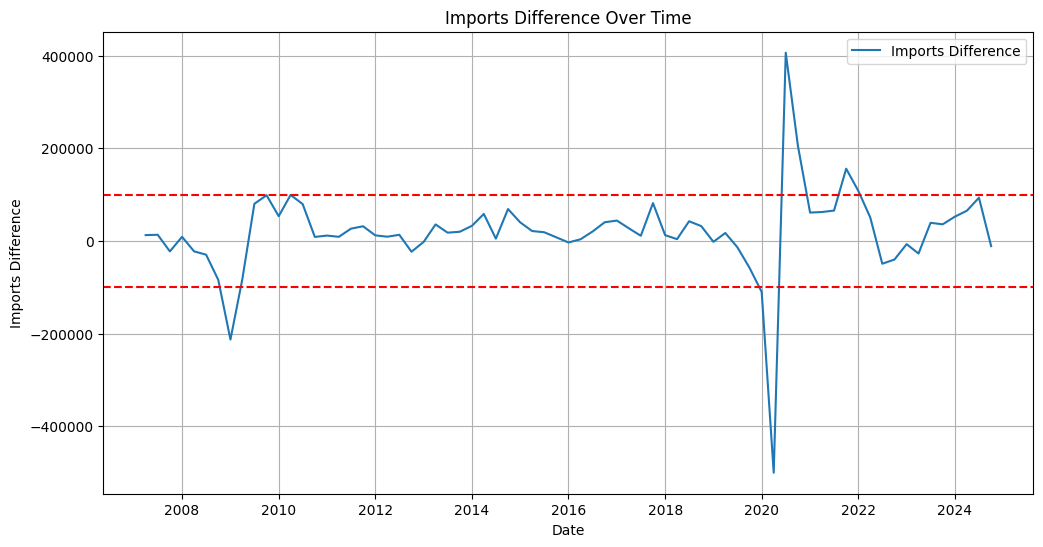

In [ ]:
# prompt: plot a line graph of imports difference from df_diff with matplotlib

import matplotlib.pyplot as plt

# Assuming df_diff is your DataFrame with the 'imports_difference' column and a DatetimeIndex



plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(df_diff.index, df_diff['imports_difference'], label='Imports Difference')
plt.xlabel('Date')
plt.ylabel('Imports Difference')
plt.title('Imports Difference Over Time')
plt.axhline(y=100000, color='r', linestyle='--')
plt.axhline(y=-100000, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

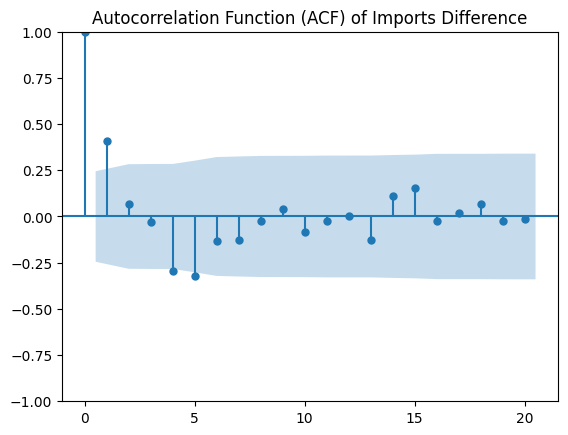

<Figure size 1200x600 with 0 Axes>

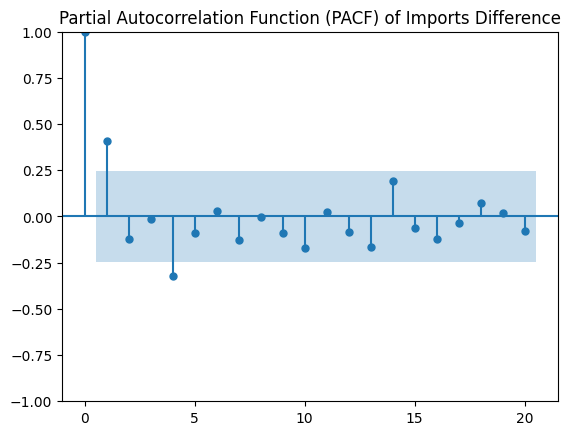

In [ ]:
# prompt: graph the autocorrelation function and partial autocorrelation functions for imports_difference in df_diff, excluding any values above 100000 or below -100000

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Filter out values above 100000 and below -100000
df_diff_filtered = df_diff[(df_diff['imports_difference'] <= 100000) & (df_diff['imports_difference'] >= -100000)]

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df_diff_filtered['imports_difference'], lags=20)  # Adjust lags as needed
plt.title('Autocorrelation Function (ACF) of Imports Difference')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df_diff_filtered['imports_difference'], lags=20)  # Adjust lags as needed
plt.title('Partial Autocorrelation Function (PACF) of Imports Difference')
plt.show()


In [ ]:
import requests
import pandas as pd
from google.colab import userdata

# Retrieve BEA API key from Google Colab secrets
BEA_API_key = userdata.get('BEA_API_key')

# ====== USER INPUT ======
user_id = BEA_API_key  # Replace with your actual BEA API key
tables = {
    "T10101": {"name": "GDP & Economic Indicators", "lines": ["1"]},  # Table 1.1.3 - GDP
    "T30200": {"name": "Government Receipts & Outlays", "lines": ["6"]},  # Table 3.2 - Total Receipts
    "T40206B": {"name": "Government Current Expenditures (Detailed)", "lines": ["94"]}  # Table 4.2.6B - Specific expenditure
}
start_year = 2007
end_year = 2024
frequency = "Q"  # A = Annual, Q = Quarterly, M = Monthly
# ========================

# Convert year range to comma-separated string
years = ",".join(str(year) for year in range(start_year, end_year + 1))

# Base API URL
base_url = "https://apps.bea.gov/api/data"

def fetch_bea_data(table_name, lines):
    """Fetches BEA data for a specific table and returns a formatted DataFrame."""
    params = {
        "UserID": user_id,
        "method": "GetData",
        "DataSetName": "NIPA",
        "TableName": table_name,
        "Frequency": frequency,
        "Year": years,
        "ResultFormat": "JSON"
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        try:
            df = pd.DataFrame(data["BEAAPI"]["Results"]["Data"])

            # Convert TimePeriod to datetime
            df["Date"] = pd.PeriodIndex(df["TimePeriod"], freq='Q').to_timestamp()

            # Ensure numerical values
            df['DataValue'] = pd.to_numeric(df['DataValue'].str.replace(',', '', regex=False), errors='coerce')

            # Filter only the required lines
            df = df[df["LineNumber"].isin(lines)]

            # Debugging: Print missing values in time periods
            print(f"\nFetched {table_name}: {df['TimePeriod'].nunique()} unique periods")

            # Pivot the table safely
            df = df.pivot_table(index="Date", columns="LineDescription", values="DataValue", aggfunc="first")

            # Rename columns with table identifiers
            df.columns = [f"{col} ({tables[table_name]['name']})" for col in df.columns]

            return df
        except KeyError:
            print(f"Unexpected JSON structure for Table {table_name}: {data}")
            return None
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

# Fetch data for selected tables & lines
dataframes = {table: fetch_bea_data(table, info["lines"]) for table, info in tables.items()}
dataframes = {k: v for k, v in dataframes.items() if v is not None}  # Remove None values

# Standardize the date index before merging
# for key, df in dataframes.items():
#    df.index = df.index.to_period("Q")  # Convert to quarterly periods to align

# Merge all DataFrames on TimePeriod
if dataframes:
    # Start merging with the first DataFrame
    merged_df = None
    for key, df in dataframes.items():
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.merge(df, left_index=True, right_index=True, how="outer")  # Keep all data

    # Debugging: Print rows with NaN values
    missing_values = merged_df.isna().sum(axis=1)
    if missing_values.any():
        print("\nRows with missing values (check for time misalignment):")
        print(merged_df[missing_values > 0])

    # Display the merged DataFrame
    print("\nMerged DataFrame:")
    print(merged_df.head())
    print(merged_df.dtypes)
else:
    print("No data retrieved from BEA API.")



Fetched T10101: 72 unique periods

Fetched T30200: 72 unique periods

Fetched T40206B: 72 unique periods

Merged DataFrame:
            Gross domestic product (GDP & Economic Indicators)  \
Date                                                             
2007-01-01                                                1.2    
2007-04-01                                                2.5    
2007-07-01                                                2.3    
2007-10-01                                                2.5    
2008-01-01                                               -1.7    

            Customs duties (Government Receipts & Outlays)  \
Date                                                         
2007-01-01                                           28430   
2007-04-01                                           28229   
2007-07-01                                           28982   
2007-10-01                                           29531   
2008-01-01                              

In [ ]:
merged_df.index.dtype

dtype('O')

In [ ]:
import requests
import pandas as pd
from google.colab import userdata

# Retrieve FRED API key from Google Colab secrets
FRED_API_key = userdata.get('FRED_API_key')

# ====== USER INPUT ======
series_id = "FEDFUNDS"  # Federal Funds Rate
start_date = "2007-01-01"
end_date = "2024-12-31"
frequency = "q"  # Quarterly
# ========================

# Base API URL for FRED
fred_base_url = f"https://api.stlouisfed.org/fred/series/observations"

# Parameters for FRED API request
params = {
    "series_id": series_id,
    "api_key": FRED_API_key,
    "file_type": "json",
    "observation_start": start_date,
    "observation_end": end_date,
    "frequency": frequency,  # Get quarterly data
    "aggregation_method": "avg",  # Average interest rate per quarter
}

# Fetch data from FRED API
response = requests.get(fred_base_url, params=params)

if response.status_code == 200:
    data = response.json()

    # Convert response into DataFrame
    fedfunds_df = pd.DataFrame(data["observations"])

    # Convert date column to datetime format and set as index
    fedfunds_df["date"] = pd.to_datetime(fedfunds_df["date"])
    fedfunds_df = fedfunds_df.drop(columns=['realtime_start', 'realtime_end'])
    fedfunds_df.set_index("date", inplace=True)

    # Convert value column to numeric
    fedfunds_df["value"] = pd.to_numeric(fedfunds_df["value"], errors="coerce")

    # Rename column for clarity
    fedfunds_df.rename(columns={"value": "Federal Funds Rate (FRED)"}, inplace=True)

    # Display the fetched data
    print(fedfunds_df.head())
    print(fedfunds_df.dtypes)

else:
    print(f"Error {response.status_code}: {response.text}")

# ================== Merge with Existing BEA Data ==================


# Merge the Federal Funds Rate data with the existing BEA dataset
final_merged_df = merged_df.join(fedfunds_df, how="left")

# Display the final merged DataFrame
print(final_merged_df.head())
print(final_merged_df.dtypes)


            Federal Funds Rate (FRED)
date                                 
2007-01-01                       5.26
2007-04-01                       5.25
2007-07-01                       5.07
2007-10-01                       4.50
2008-01-01                       3.18
Federal Funds Rate (FRED)    float64
dtype: object
            Gross domestic product (GDP & Economic Indicators)  \
Date                                                             
2007-01-01                                                1.2    
2007-04-01                                                2.5    
2007-07-01                                                2.3    
2007-10-01                                                2.5    
2008-01-01                                               -1.7    

            Customs duties (Government Receipts & Outlays)  \
Date                                                         
2007-01-01                                           28430   
2007-04-01                        

In [ ]:
# prompt: generate a new column called weighted average tariff rate which equals customs duties divided by imports of goods and services

# Assuming your merged DataFrame is named 'final_merged_df'
# You'll need to adjust column names based on how you named them in your code
try:
  final_merged_df['Weighted Average Tariff Rate'] = final_merged_df['Customs duties (Government Receipts & Outlays)'] / final_merged_df['Imports of goods and services (Government Current Expenditures (Detailed))']
except KeyError:
  print("Error: One or more columns are not found in the dataframe. Please verify your column names.")

print(final_merged_df.head())



            Gross domestic product (GDP & Economic Indicators)  \
Date                                                             
2007-01-01                                                1.2    
2007-04-01                                                2.5    
2007-07-01                                                2.3    
2007-10-01                                                2.5    
2008-01-01                                               -1.7    

            Customs duties (Government Receipts & Outlays)  \
Date                                                         
2007-01-01                                           28430   
2007-04-01                                           28229   
2007-07-01                                           28982   
2007-10-01                                           29531   
2008-01-01                                           29494   

            Imports of goods and services (Government Current Expenditures (Detailed))  \
Date        

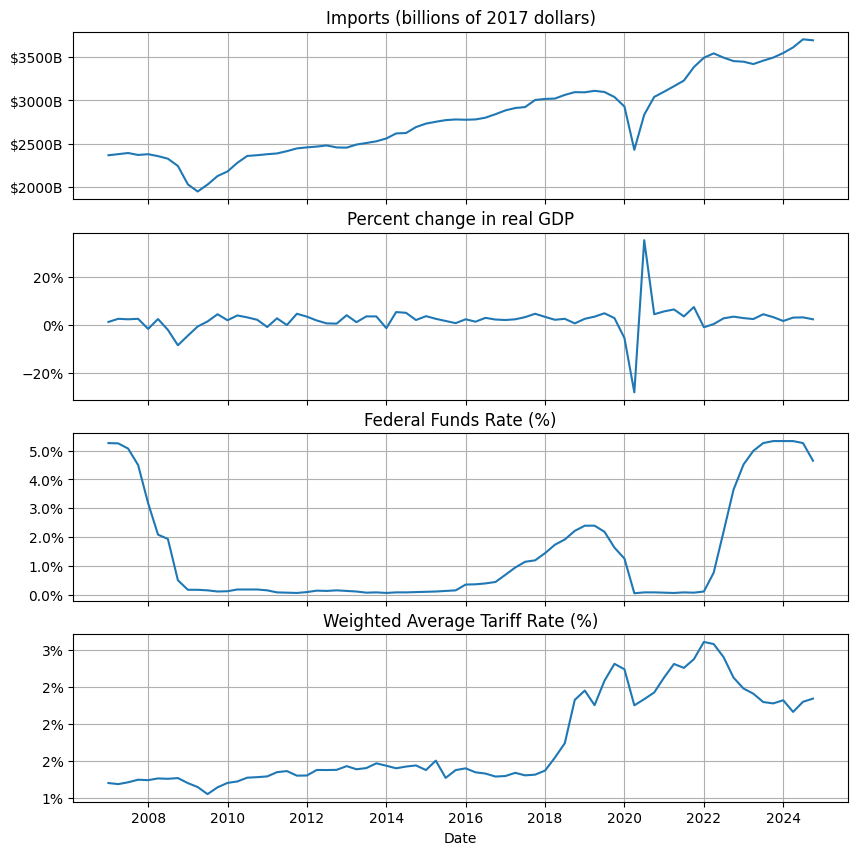

In [ ]:
# prompt: plot each column without using a for loop, stacked on top of one another

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker  # Import mticker


# Define the columns to plot and their custom labels
column_labels = {
    'Imports of goods and services (Government Current Expenditures (Detailed))': 'Imports (billions of 2017 dollars)',
    'Gross domestic product (GDP & Economic Indicators)': 'Percent change in real GDP',
    'Federal Funds Rate (FRED)': 'Federal Funds Rate (%)',
    'Weighted Average Tariff Rate': 'Weighted Average Tariff Rate (%)'
}

# Ensure all requested columns exist in DataFrame
columns_to_plot = [col for col in column_labels.keys() if col in final_merged_df.columns]

# Create subplots dynamically
fig, axs = plt.subplots(len(columns_to_plot), 1, sharex=True, figsize=(10, 10))

# If only one subplot, make axs a list to avoid indexing issues
if len(columns_to_plot) == 1:
    axs = [axs]

# Loop through columns and plot with custom labels
for i, col in enumerate(columns_to_plot):
    axs[i].plot(final_merged_df.index, final_merged_df[col], label=column_labels[col], linewidth=1.5)
    axs[i].set_title(column_labels[col])  # Custom y-axis label
    axs[i].grid(True)

axs[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1000:.0f}B"))
axs[1].yaxis.set_major_formatter(mticker.PercentFormatter())  # Apply percentage formatting
axs[2].yaxis.set_major_formatter(mticker.PercentFormatter())  # Apply percentage formatting
axs[3].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))



# Set common x-axis label
plt.xlabel('Date')

plt.show()



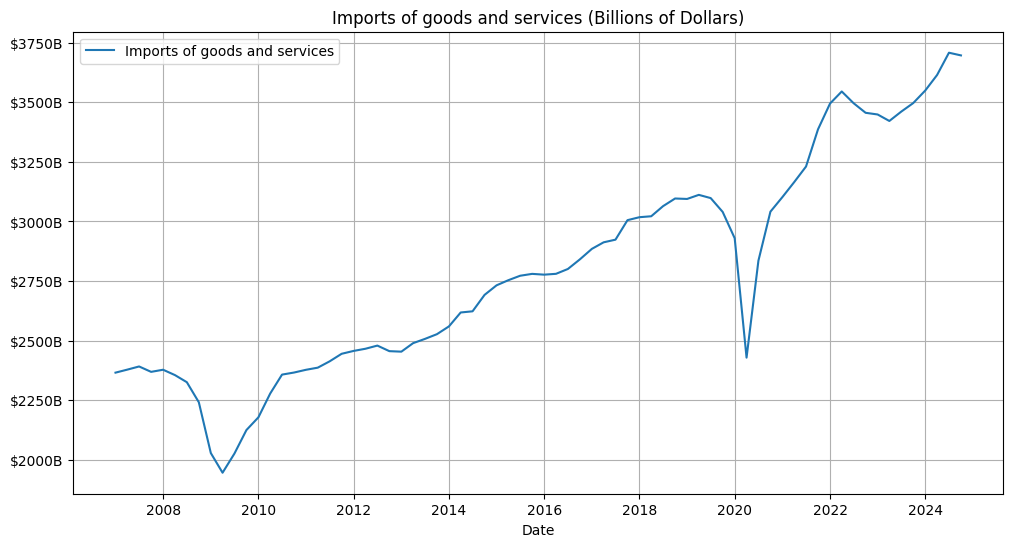

In [ ]:
# prompt: plot 'Imports of goods and services (Government Current Expenditures (Detailed))'

# Assuming your merged DataFrame is named 'final_merged_df'
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(final_merged_df.index, final_merged_df['Imports of goods and services (Government Current Expenditures (Detailed))'], label='Imports of goods and services')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1000:.0f}B"))
plt.title('Imports of goods and services (Billions of Dollars)')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
from google.colab import userdata

# Replace with your GitHub username and ensure token is stored in Colab secrets
username = "dmst0ut"
token = userdata.get("github_token")

# Git config
!git config --global user.email "dmstout611@gmail.com.com"
!git config --global user.name "dmst0ut"

# Clone your private repo (replace with your repo name)
repo_url = f"https://{token}@github.com/{username}/importforecasting_group2.git"
!git clone $repo_url



fatal: destination path 'importforecasting_group2' already exists and is not an empty directory.


In [10]:
%cd /content/importforecasting_group2



/content/importforecasting_group2


In [12]:

# Add all changes
!git add .

# Commit
!git commit -m "Update from Google Colab"

# Push to main (or your desired branch)
!git push origin main

On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/dmst0ut/importforecasting_group2.git'


In [13]:
!rm /content/importforecasting_group2

rm: cannot remove '/content/importforecasting_group2': Is a directory


In [14]:
import os
from google.colab import userdata


# GitHub credentials
username = "dmst0ut"
token = userdata.get("github_token")

repo = "importforecasting_group2"  # Replace with your repo name
filename = "Imports_Explore.ipynb"  # Optional: rename it if you want

# Save the notebook locally
notebook_path = f"/content/{filename}"
from IPython.display import Javascript
display(Javascript(f'IPython.notebook.save_checkpoint();'))

# Give Colab a moment to save
import time
time.sleep(2)

# Move notebook to repo folder
!git clone https://{token}@github.com/{username}/{repo}.git
!mv {filename} {repo}/
%cd {repo}
!git config --global user.email "you@example.com"
!git config --global user.name "{username}"
!git add {filename}
!git commit -m "Add notebook from Colab"
!git push origin main  # Or another branch


<IPython.core.display.Javascript object>

Cloning into 'importforecasting_group2'...
mv: cannot stat 'Imports_Explore.ipynb': No such file or directory
/content/importforecasting_group2/importforecasting_group2
fatal: pathspec 'Imports_Explore.ipynb' did not match any files
On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/dmst0ut/importforecasting_group2.git'


In [18]:
import requests
import json
import IPython

# Get the current notebook name from the frontend
def get_notebook_name():
    payload = {
        "command": "notebook:getNotebookMetadata",
        "args": [],
        "silent": False
    }
    response = IPython.notebook.kernel.execute_request(payload)
    return response

# Workaround to manually set the notebook name
notebook_name = "Imports_Explore.ipynb"  # 🔁 Replace with your actual notebook name

# Save notebook to /content
import shutil
shutil.copyfile(f"/content/drive/MyDrive/{notebook_name}", f"/content/{notebook_name}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Imports_Explore.ipynb'

In [17]:
filename = "Imports_Explore.ipynb"
!ls /content


importforecasting_group2  sample_data
